In [51]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [52]:
df = pd.read_csv("/Users/hemantkumar/Developer/hackathon/sih/model/dataset/PJME_hourly.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [54]:
# convert the Datetime column to Datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# indexing the Datetime column after the transformation
df.set_index('Datetime', inplace=True)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [55]:
# checking missing data
df.isna().sum()

PJME_MW    0
dtype: int64

In [56]:
# Let see at the years in the data set
years = df.index.year.unique()
years

Index([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018],
      dtype='int32', name='Datetime')

In [57]:
# Let's see the average energy consumed per year
df_yearly_avg = df['PJME_MW'].resample('Y').mean()
df_yearly_avg.to_frame()

,PJME_MW
Datetime,
2002-12-31,31565.617106
2003-12-31,31698.758621
2004-12-31,32270.434867
2005-12-31,33310.478648
2006-12-31,32409.269696
2007-12-31,33613.468600
2008-12-31,32929.593373
2009-12-31,31851.533683
2010-12-31,33101.172662


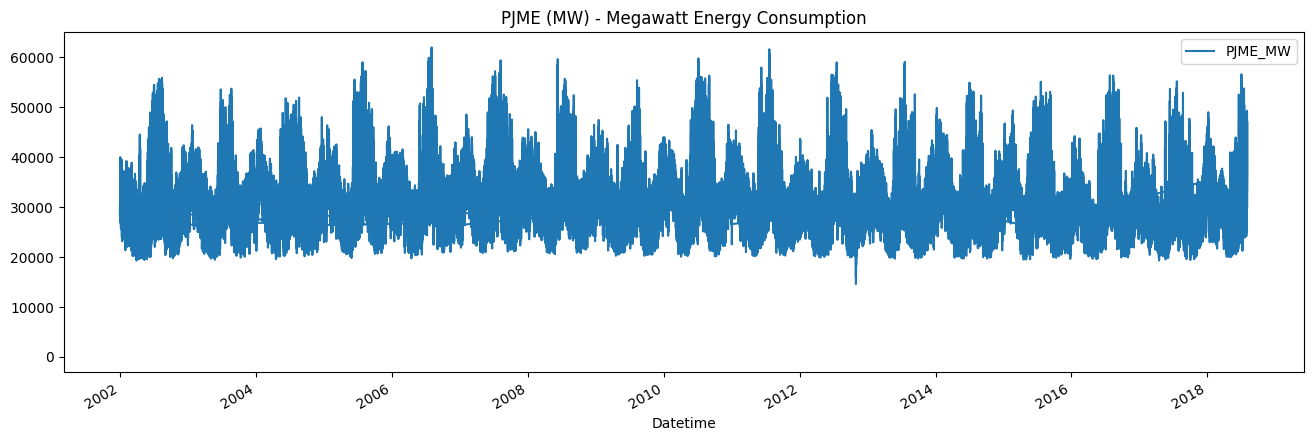

In [58]:
df.plot(figsize=(16,5),legend=True)
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)

plt.title('PJME (MW) - Megawatt Energy Consumption')

plt.show()

In [59]:
def normalize_data(df):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
    df['PJME_MW'] = normalized_data
    return df, scaler

df_norm, scaler = normalize_data(df)
df_norm.shape

(145366, 1)

In [60]:
df_norm

,PJME_MW
Datetime,
2002-12-31 01:00:00,0.251849
2002-12-31 02:00:00,0.223386
2002-12-31 03:00:00,0.211314
2002-12-31 04:00:00,0.207500
2002-12-31 05:00:00,0.217339
...,...
2018-01-01 20:00:00,0.626567
2018-01-01 21:00:00,0.615338
2018-01-01 22:00:00,0.586917


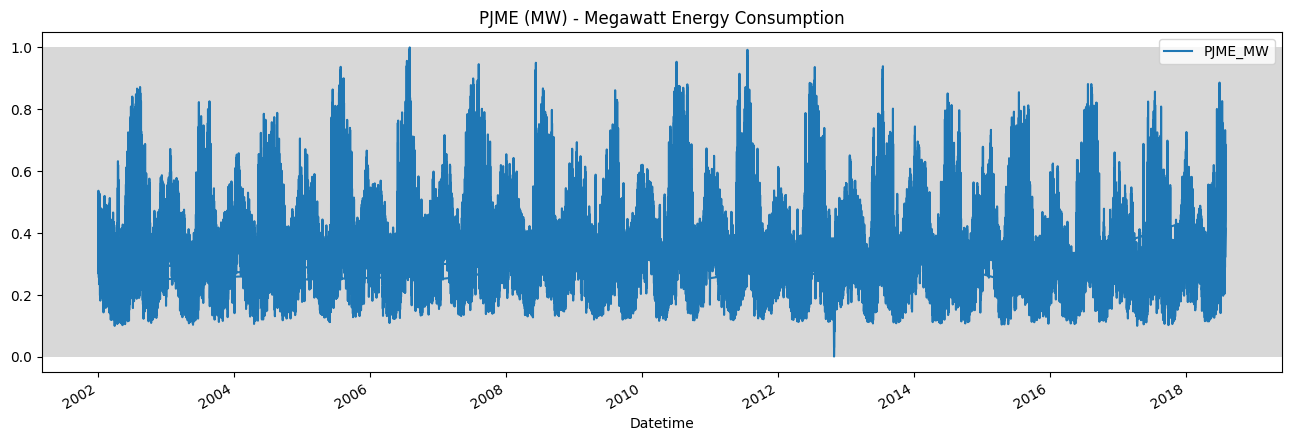

In [61]:
# Now after normalization we can observe that the data range on y-axis is 0.0 - 1.0

df.plot(figsize=(16,5),legend=True)
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)

plt.title('PJME (MW) - Megawatt Energy Consumption')

plt.show()

In [62]:
# 2017-02-13 after this date we will choose the test set
split_date = '2017-02-13'

DOM_train = df_norm.loc[df_norm.index <= split_date].copy()
DOM_test = df_norm.loc[df_norm.index > split_date].copy()

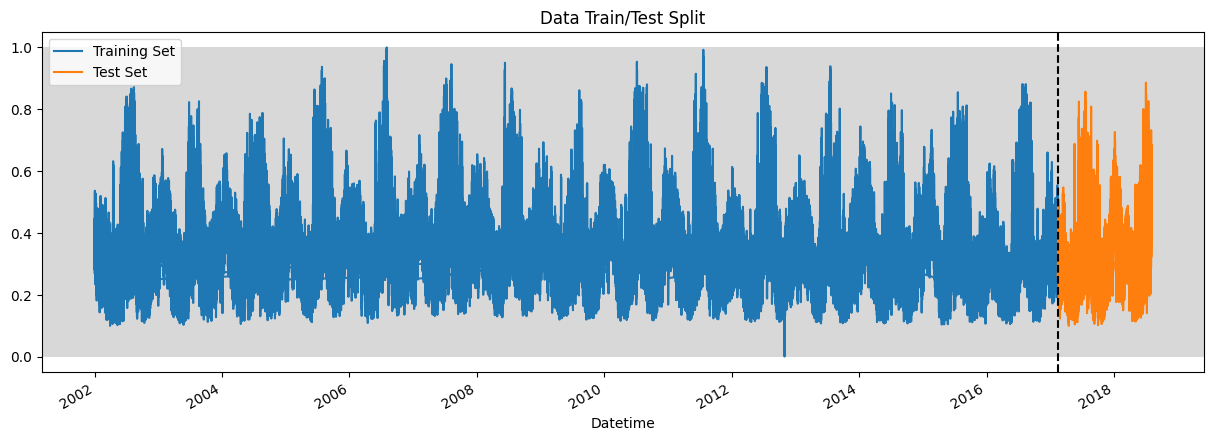

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))
DOM_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
DOM_test.plot(ax=ax, label='Test Set')
ax.axvline('2017-02-13', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.show()

In [66]:
def load_data(data, seq_len):
    X_train = []
    y_train = []

    for i in range(seq_len, len(data)):
        X_train.append(data.iloc[i-seq_len : i, 0])
        y_train.append(data.iloc[i, 0])

    # last 6189 days are going to be used in test
    X_test = X_train[110000:]
    y_test = y_train[110000:]

    # first 110000 days are going to be used in training
    X_train = X_train[:110000]
    y_train = y_train[:110000]

    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # reshape data to input into RNN&LSTM models
    X_train = np.reshape(X_train, (110000, seq_len, 1))

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]

In [67]:
seq_len = 20

# Let's create train, test data
X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (35346, 20, 1)
y_test.shape =  (35346,)


In [68]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))


rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))


rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_14 (SimpleRNN)       │ (None, 20, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ (None, 20, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 20, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 20, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_18 (SimpleRNN)       │ (None, 20, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_19 (SimpleRNN)       │ (None, 20, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_20 (SimpleRNN)       │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,161 (82.66 KB)

 Trainable params: 21,161 (82.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=32, batch_size=1000)


Epoch 1/32
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 460ms/step - loss: 0.0044
Epoch 2/32
 13/110 ━━━━━━━━━━━━━━━━━━━━ 43s 444ms/step - loss: 0.0015

In [46]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

1105/1105 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
R2 Score of RNN model =  0.9460996116436207


In [47]:
# Reverse transform scaler to convert to real values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
rnn_predictions_inverse = scaler.inverse_transform(rnn_predictions)

# Get values after inverse transformation
y_test_inverse = y_test_inverse.flatten()
rnn_predictions_inverse = rnn_predictions_inverse.flatten()

In [48]:
last_6169_index_dates = df.index[-6169:]

# Now let's see our actual y and predicted y values as dataframes
results_RNN = pd.DataFrame({"Date":last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': rnn_predictions_inverse})
results_RNN

ValueError: All arrays must be of the same length

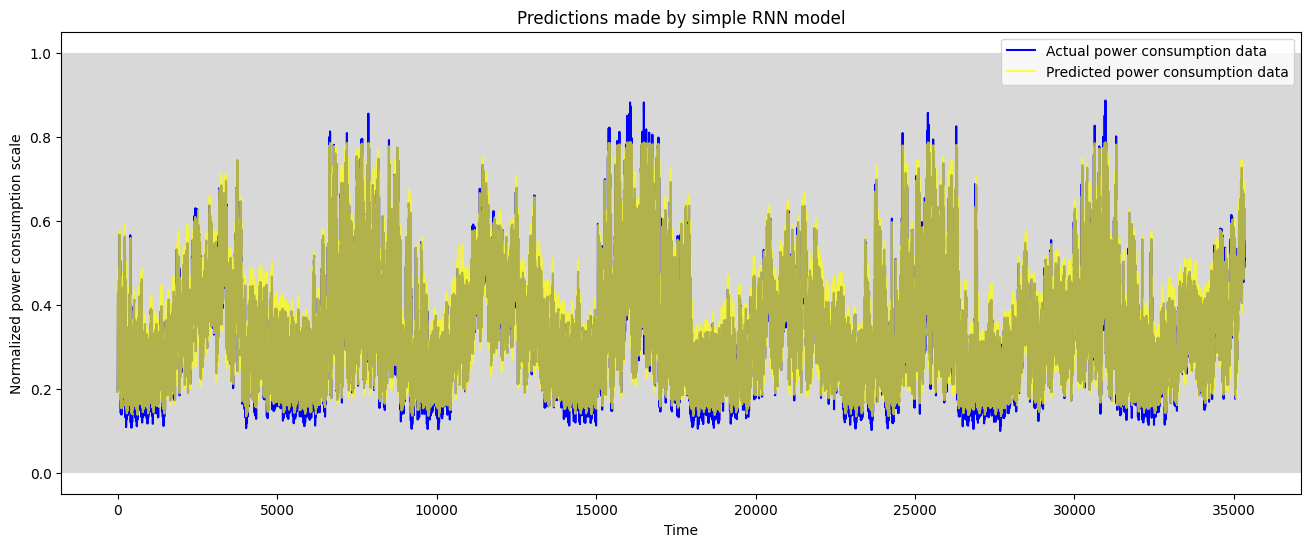

In [50]:
plt.figure(figsize=(16,6))
plt.plot(y_test, color='blue',label='Actual power consumption data')
plt.plot(rnn_predictions, alpha=0.7, color='yellow', label='Predicted power consumption data')
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.title("Predictions made by simple RNN model")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

In [49]:
with open('/Users/hemantkumar/Developer/hackathon/sih/model/model(pickle)/rnnmodel2.pkl','wb') as file:
    pickle.dump(rnn_model,file)